# MultiClass Classification: Predicting Shelter Animal Outcomes

__dataset__: Austin humane society animal outcomes, 2013- 2016. I downloaded the dataset from Kaggle as part of a past competition: https://www.kaggle.com/c/shelter-animal-outcomes/data

The goal of this project is to try to predict animal outcomes (adoption, transfer, etc.) based on the animals' individual attributes (age, sex, etc). <br>
- part 1: visualization of the dataset to understand distributions, trends and correlations. Also try to answer the question: which features are most important in determining animal outcomes?
- part 2: Encode categoric variables, deal with null values, and prepare dataset for training
- part 3: Applying machine learning classifiers to the dataset

# 1) Data Visualization

import modules, read in data

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import math
import sklearn.metrics as skm
from scipy.stats import zscore
import pandas as pd
import numpy as np
import plotting_tools as ptool

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
ahs_train_df = pd.read_csv(r"C:\Users\Mattz\OneDrive\Studies\Data Projects\humane_society\train.csv.gz", compression='gzip')

- Data is there for individual animals: animalID, name, time of outcome, etc. <br>
- Possible outcome types are adoption, death, euthanesia, return to owner or transfer <br>
- Data is accumulated for dogs and cats only. The age and sex (neutered/spayed or not) on outcome is tracked, as well as the color and breed. Of course, the breed is a best approximation (which studies have shown are not that accurate whatsoever, see https://thebark.com/content/shelter-dogs-fate-can-rest-what-breed-he-labeled)

In [11]:
print(np.unique(ahs_train_df["OutcomeType"]))

['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']


In [12]:
ahs_train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [13]:
print(ahs_train_df.dtypes)

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object


most of the data is in categorical format. 'AgeuponOutcome' can be converted to numeric. Unfortunately, 'length of stay' is not included in the dataset, which would be interesting to see

There are five possible outcome types: adoption, transfer, return to owner, euthanasia or death in the shelter. These are the categories we will try to predict for every shelter animal based on their particular combination of features. The majority of outcomes are adoption and transfers. The other three are return to owner, euthanasia or dying in shelter

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64


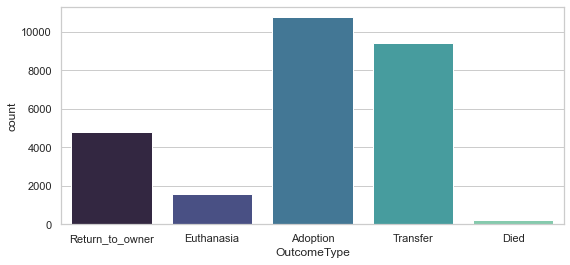

In [15]:
fig = plt.figure(figsize=(9, 4))
sns.set_theme(style="whitegrid")
sns.countplot(x="OutcomeType", data=ahs_train_df, palette="mako")

print(ahs_train_df["OutcomeType"].value_counts())

__How many cats and dogs__

In [16]:
animalCount = ahs_train_df['AnimalType'].value_counts()
print("Number of Cats: {}".format(animalCount["Cat"]))
print("Number of Dogs: {}".format(animalCount["Dog"]))
total = animalCount["Cat"]+animalCount["Dog"]

Number of Cats: 11134
Number of Dogs: 15595


1.401% more dogs than cats.


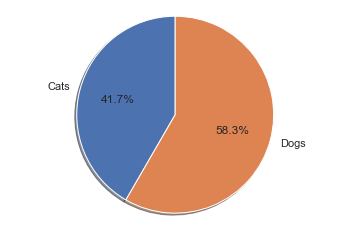

In [17]:
print('{:.4}% more dogs than cats.'.format(animalCount["Dog"]/ animalCount["Cat"]))

labels = 'Cats', 'Dogs'
sizes = [animalCount["Cat"]/total, animalCount["Dog"]/total]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

__How old are the animals when they get adopted?__

Since the 'AgeuponOutcome' variable is categorical (ages are spelled out), we could use a function which converts all values to numeric. In this case, we will look at ages (in years). Note that this dataset stops counting weeks and months after 1 year of age. Also it is unclear to what extent the listed ages are precisely known.

In [18]:
def age_in_years(age):
    age = str(age)
    if "year" in age[2:]:
        return int(age[:2])
    elif "week" in age[2:]:
        return round(float(age[:2]) * (1/52.1429), 3)
    elif "month" in age[2:]:
        return round(float(age[:2]) * (1/12.0), 3)
    elif "day" in age[2:]:
        return round(float(age[:2]) * (1/365.2422), 3)
    elif age == "nan":
        return "nan"
    else:
        return "calculation invalid"

some test calculations for this new function

In [19]:
print("age in years: {}".format(age_in_years("3 years")))
print("age in years: {}".format(age_in_years("4 days")))
print("age in years: {}".format(age_in_years("1 year")))
print("age in years: {}".format(age_in_years("5 weeks")))
print("age in years: {}".format(age_in_years("11 months")))
print("age in years: {}".format(age_in_years("nan")))
print("age in years: {}".format(age_in_years("asdf")))

age in years: 3
age in years: 0.011
age in years: 1
age in years: 0.096
age in years: 0.917
age in years: nan
age in years: calculation invalid


looks good! Now convert ages in dataset to numeric:

In [20]:
age_list = [age_in_years(age) for age in ahs_train_df["AgeuponOutcome"]]

In [21]:
print(age_list[:10]) # confirm working

[1, 1, 2, 0.058, 2, 0.083, 0.058, 0.058, 0.417, 1]


In [23]:
ahs_train_df["ageYrs"] = age_list  # add new variable to dataset
#ahs_train_df.drop(columns="AgeuponOutcome")  # drop categoric Age variable

In [24]:
ahs_train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ageYrs
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.058
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2


any invalid ages? if not, let's convert to numeric type (float)

In [26]:
naRows = ahs_train_df[ahs_train_df['ageYrs']=='calculation invalid']
print(naRows) #looks good

# convert to float numeric
ahs_train_df = ahs_train_df.astype({'ageYrs': 'float'})
# ahs_train_df.dtypes

Empty DataFrame
Columns: [AnimalID, Name, DateTime, OutcomeType, OutcomeSubtype, AnimalType, SexuponOutcome, AgeuponOutcome, Breed, Color, ageYrs]
Index: []


Most shelter animals are younger: The mean age is 2.12 yrs old while the median age is only 1 year old

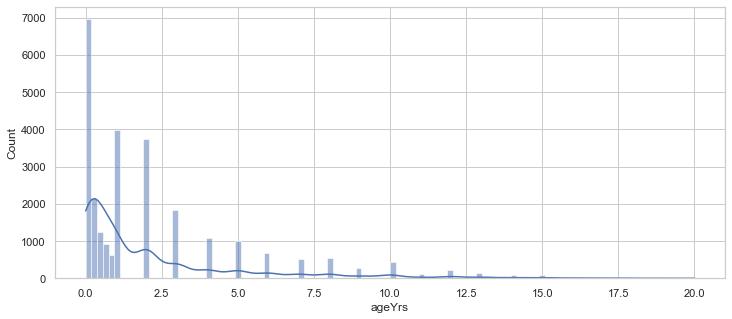

Animal Age (yrs) at Outcome stat summary:
 count    26711.000000
mean         2.177259
std          2.965757
min          0.000000
25%          0.167000
50%          1.000000
75%          3.000000
max         20.000000
Name: ageYrs, dtype: float64

Median age: 1.0


In [27]:
fig = plt.figure(figsize=(12, 5))
sns.histplot(data=ahs_train_df, x='ageYrs', kde=True)
plt.show()
# fig = plt.figure(figsize=(12, 5))
# ax = sns.boxplot(x=ahs_train_df['ageYrs'])

print("Animal Age (yrs) at Outcome stat summary:\n {}".format(ahs_train_df['ageYrs'].describe()))
print('\nMedian age: {}'.format(ahs_train_df['ageYrs'].median()))

__create some age groupings to view outcomes by age groups__

In [43]:
def age_group(age):
    if 0<=age<1:
        return "less than 1yr old"
    elif 1<=age<3:
        return "1-3yrs old"
    elif 3<=age<5:
        return "3-5yrs old"
    elif 5<=age<8:
        return "5-8yrs old"
    elif age >= 8:
        return "older than 8 yrs"
    else:
        return np.nan

In [44]:
age_groups = [age_group(x) for x in ahs_train_df["ageYrs"]]

In [45]:
ahs_train_df["ageGroup"] = age_groups

In [46]:
# #view new grouping in dataset
# ahs_train_df.head()

we see from the below plot that age is an important factor in determining the outcome for the shelter animals. <br>
- Adoption rates are highest for animals less than 1 year old (puppies and kittens)-- adoption rates then drop off by nearly 50% for 1-2yr olds before decreasing exponentially for older age groups. <br>
- Interesingly, transfers display the same tendency as adoptions across the various age groups. <br>
- Older animals are more commonly returned to the owners <br>
- Euthanasia rates are highest for the youngest and oldest age groups, while kennel death outcomes are highest for the youngest animals.

Text(0.5, 1.0, 'Animal Outcomes by Age Group')

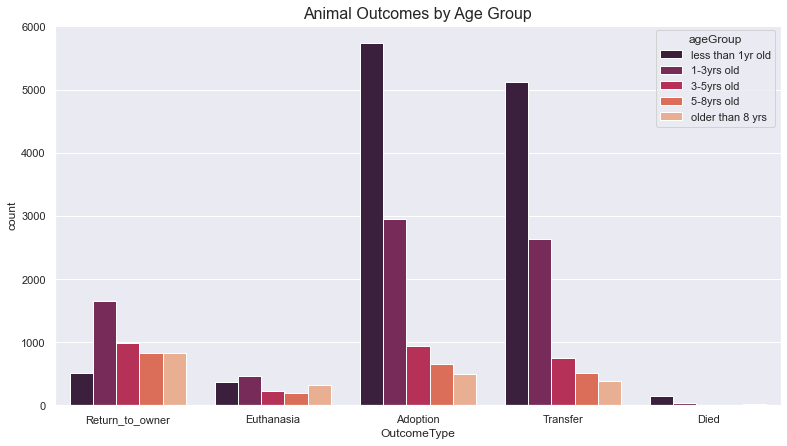

In [48]:
# print(ahs_train_df['OutcomeType'].groupby(ahs_train_df['ageGroup']).value_counts())
fig = plt.figure(figsize=(13, 7))
sns.set_theme(style="darkgrid")
sns.countplot(x="OutcomeType", hue="ageGroup", data=ahs_train_df, hue_order = ["less than 1yr old", "1-3yrs old", "3-5yrs old", "5-8yrs old", "older than 8 yrs"], palette="rocket")
plt.title("Animal Outcomes by Age Group", fontsize=16)

__Sex on Outcome (Neuter/Spay Numbers)__

most animals in the shelter are neutered or spayed. This ratio is about 2.5:1 for neutered/spayed animals to those which are 'intact' 

In [50]:
sexes = ahs_train_df['SexuponOutcome'].value_counts()
print(sexes)
ratio = round(((sexes[0]+sexes[1]) / (sexes[2]+sexes[3])), 2)
print('\nratio of neutered/spayed animals to intact: {}'.format(str(ratio)))

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

ratio of neutered/spayed animals to intact: 2.64


<AxesSubplot:xlabel='SexuponOutcome', ylabel='count'>

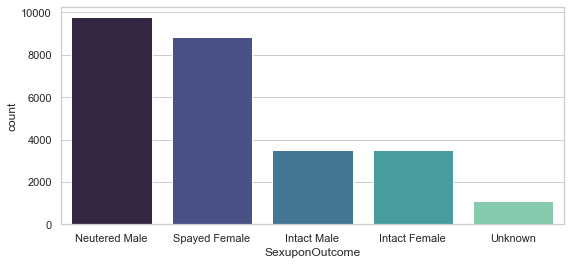

In [51]:
fig = plt.figure(figsize=(9, 4))
sns.set_theme(style="whitegrid")
sns.countplot(x="SexuponOutcome", data=ahs_train_df, palette="mako")

let's add a Boolean feature to the dataset which describes whether the animal is intact (True) or neutered/spayed (False) -- this can easily be converted to numeric (0 / 1) later

In [58]:
def count_sex(val):
    if val in ['Neutered Male', 'Spayed Female']:
        return True # neutered or spayed
    #elif "Intact" in val:
    elif val in ["Intact Male", "Intact Female"]:
        return False   # intact sex
    else:
        return np.nan   # unknown sex

In [59]:
sex_list = [count_sex(x) for x in ahs_train_df["SexuponOutcome"]]

In [60]:
# add this new feature to the dataframe
ahs_train_df["neutOrSpay"] = sex_list

In [61]:
#ahs_train_df=ahs_train_df.drop(columns="AgeuponOutcome")
ahs_train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ageYrs,ageGroup,neutOrSpay
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1.000,1-3yrs old,True
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1.000,1-3yrs old,True
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2.000,1-3yrs old,True
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.058,less than 1yr old,False
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2.000,1-3yrs old,True


the sex of some animals has not been identified by the shelter and thus are represented by 'nan'

In [62]:
print(np.unique(ahs_train_df["neutOrSpay"]))

[False nan False ... True nan True]


view outcomes by animal sex. From the below plot we see that:

- of the adopted animals, only 3.5% are intact at the time of adoption. Of note, it is unclear if the animal was neutered/spayed for the purpose of adoption (before the adoption), or if the animal was already neutered/spayed before the adopters met them. 
- More neutered/spayed animals are returned to their owners compared to intact ones -- over 5x the returned animals are neutered/spayed 
- 150% of the animals which undergo euthenasia are intact, and 1.36x more transfers are for intact animals. Only 37 neutered/spayed animals died in shelther compared with 135 deaths of intact animals. 

Overall, we see that animal sex is an important differentiator for outcome types. 

Text(0.5, 1.0, 'Animal Outcomes by Intact/Spayed Criteria')

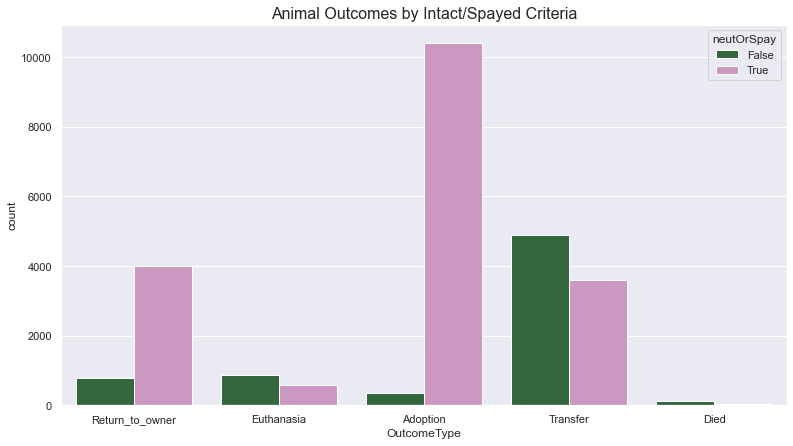

In [65]:
fig = plt.figure(figsize=(13, 7))
sns.set_theme(style="darkgrid")
sns.countplot(x="OutcomeType", hue="neutOrSpay", data=ahs_train_df, palette="cubehelix")
plt.title("Animal Outcomes by Intact/Spayed Criteria", fontsize=16)

In [67]:
rates = ahs_train_df['OutcomeType'].groupby(ahs_train_df['neutOrSpay']).value_counts()
print('Adoption ratio intact/ns: {}'.format(str(rates[0.0]["Adoption"]/rates[1.0]["Adoption"])))
print('Return to owner ratio intact/ns: {}'.format(str(rates[0.0]["Return_to_owner"]/rates[1.0]["Return_to_owner"])))
print('Euthanasia ratio intact/ns: {}'.format(str(rates[0.0]["Euthanasia"]/rates[1.0]["Euthanasia"])))
print('Transfer ratio intact/ns: {}'.format(str(rates[0.0]["Transfer"]/rates[1.0]["Transfer"])))

Adoption ratio intact/ns: 0.034684857801691005
Return to owner ratio intact/ns: 0.19474342928660826
Euthanasia ratio intact/ns: 1.5243055555555556
Transfer ratio intact/ns: 1.3631035445157689


In [68]:
print(rates)

neutOrSpay  OutcomeType    
False       Transfer            4884
            Euthanasia           878
            Return_to_owner      778
            Adoption             361
            Died                 135
True        Adoption           10408
            Return_to_owner     3995
            Transfer            3583
            Euthanasia           576
            Died                  37
Name: OutcomeType, dtype: int64


We can also choose to observe these outcomes by sex on a more granular level: 

We see slight variations for each gender for the various outcome types, although overall, similar patterns are observed. I expect the intact vs neutered/spay classification to be better suited for generalized than gender specificity for most ML algorithms.

Text(0.5, 1.0, 'Animal Outcomes by Gender and Sex')

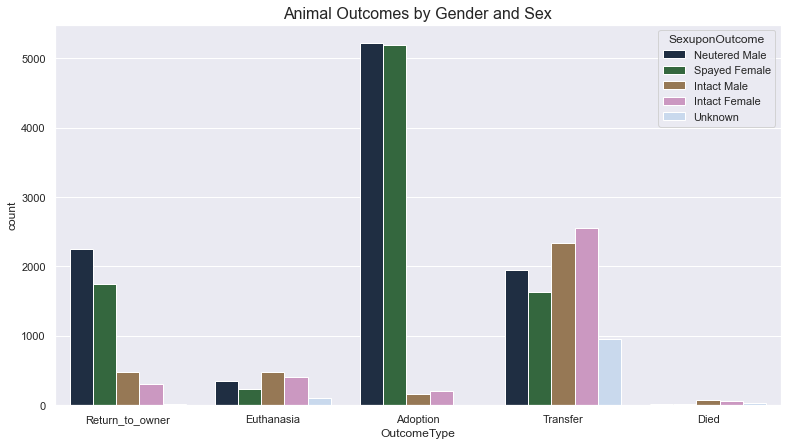

In [71]:
fig = plt.figure(figsize=(13, 7))
sns.set_theme(style="darkgrid")
sns.countplot(x="OutcomeType", hue="SexuponOutcome", data=ahs_train_df, palette="cubehelix")
plt.title("Animal Outcomes by Gender and Sex", fontsize=16)

__Outcome Type by Animal__

The differentiation of outcome results by animal species is surprising and remarkable. <br>

There are very different outcome for cats and dogs. Given the adjustment for the greater number of dogs to cats in the shelter:
- the adoption ratio is about 9:10 for cats vs dogs.
- only 0.16% of cats will be returned to owners compared to dogs
- Almost 2x more cats will be transferred to another shelther than dogs

Text(0.5, 1.0, 'Animal Outcomes by Species (unnormalized)')

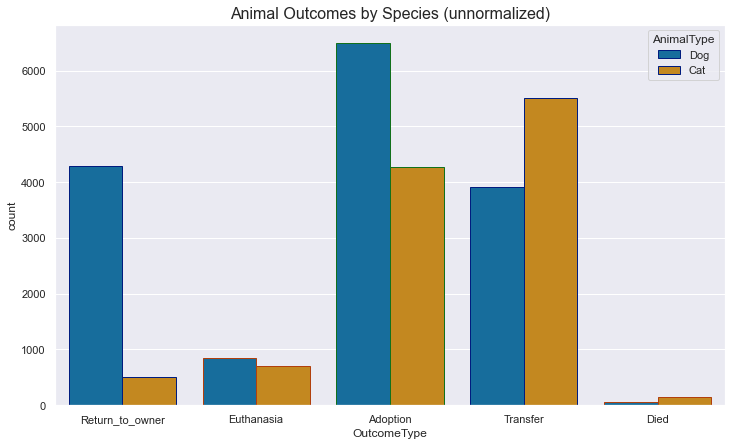

In [77]:
# print(ahs_train_df['OutcomeType'].groupby(ahs_train_df['AnimalType']).value_counts())
fig = plt.figure(figsize=(12, 7))
sns.set_theme(style="darkgrid")
sns.countplot(x="OutcomeType", hue="AnimalType", data=ahs_train_df, palette="colorblind", edgecolor=sns.color_palette("dark", 3))
plt.title("Animal Outcomes by Species (unnormalized)", fontsize=16)

Adjusted rates accounting for the greater number of dogs than cats in the shelter:

In [76]:
rates = ahs_train_df['OutcomeType'].groupby(ahs_train_df['AnimalType']).value_counts()
#print(rates)
print('Adoption ratio cat/dog: {}'.format(str(1.4*rates["Cat"]["Adoption"]/rates["Dog"]["Adoption"])))
print('Return to owner ratio cat/dog: {}'.format(str(1.4*rates["Cat"]["Return_to_owner"]/rates["Dog"]["Return_to_owner"])))
print('Euthanasia ratio cat/dog: {}'.format(str(1.4*rates["Cat"]["Euthanasia"]/rates["Dog"]["Euthanasia"])))
print('Transfer ratio cat/dog: {}'.format(str(1.4*rates["Cat"]["Transfer"]/rates["Dog"]["Transfer"])))

Adoption ratio cat/dog: 0.9205479452054793
Return to owner ratio cat/dog: 0.163322445170322
Euthanasia ratio cat/dog: 1.1763313609467454
Transfer ratio cat/dog: 1.9675772274700023


__looking into colour types__

There is a remarkable 366 unique colour types in this dataset! This is too much specificity by far. <br>
Below is a list of the most common ones. 

In [78]:
print(len(np.unique(ahs_train_df["Color"])))
print(ahs_train_df['Color'].value_counts()[:20])

366
Black/White            2824
Black                  2292
Brown Tabby            1635
Brown Tabby/White       940
White                   931
Brown/White             884
Orange Tabby            841
Tan/White               773
Tricolor                752
Blue/White              702
Black/Tan               672
White/Black             643
Brown                   639
Tan                     628
White/Brown             569
Tortie                  530
Calico                  517
Orange Tabby/White      455
Blue                    450
Brown Brindle/White     450
Name: Color, dtype: int64


We can try to reduce this complexity down to a few major categories (light, dark, white, black, black/white) to aid the classification algorithms

In [79]:
def color_sort(col):
    darks = ["brown", "chocolate", "sable", "gray", "liver"]
    colours = ["torbie","red","blue","tortie", "orange", "tricolor", "calico", "flame", "seal"]
    lights = ["cream","calico","silver", "white", "yellow", "fawn", "tan", "buff"]
    
    col = col.replace('/', ' ')
    col = col.split()[0]
   
    if col.lower() == "black":
        return 'black'
    elif any(light in col.lower() for light in lights):
        return "light"
    elif any(dark in col.lower() for dark in darks):
        return "dark"
    elif any(c in col.lower() for c in colours):
        return "coloured"
    else:
        return "other"

In [80]:
for x in ahs_train_df["Color"][:5]:
    print("specific colour: {}, sorted colour: {}".format(x, color_sort(x)))

specific colour: Brown/White, sorted colour: dark
specific colour: Cream Tabby, sorted colour: light
specific colour: Blue/White, sorted colour: coloured
specific colour: Blue Cream, sorted colour: coloured
specific colour: Tan, sorted colour: light


In [81]:
colorGroup = [color_sort(col) for col in ahs_train_df["Color"]]

In [82]:
#add this newly engineered feature to the dataset
ahs_train_df["colGroup"] = colorGroup
print(ahs_train_df["colGroup"].value_counts())

light       6928
black       6646
coloured    6418
dark        6408
other        329
Name: colGroup, dtype: int64


We have thus managed to engineer a small set of common color groups. From below, we can see common below among the different color groups. <br>
Interestingly, while adoption and euthanasia rates are pretty even across the groups, we see more light coloured animals being returned to their owners, and more coloured and black animals being transferred

The following is observed for outcome vs colour type:
- the number of adoptions is pretty evenly balanced for the different colour types. It appears slightly more light animals are adopted, but this could be a random artifact
- The euthanasia rates are steady across the colour groups
- It appears more light coloured animals are returned to owners than the other categories

Generally, the colour grouping is a 'best effort' grouping and this might be revisited in later analyses

Text(0.5, 1.0, 'Outcome by Colour Type')

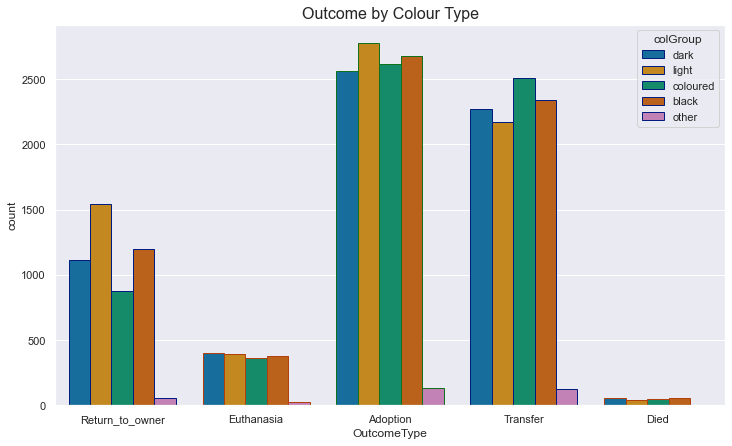

In [85]:
# print(ahs_train_df['OutcomeType'].groupby(ahs_train_df['AnimalType']).value_counts())
fig = plt.figure(figsize=(12, 7))
sns.set_theme(style="darkgrid")
sns.countplot(x="OutcomeType", hue="colGroup", data=ahs_train_df, palette="colorblind", edgecolor=sns.color_palette("dark", 3))
plt.title("Outcome by Colour Type", fontsize=16)

__names__

There are a ton of names for the shelter animals. But a surprisingly high number - 28.8% of animals do not have any name at all! <br>
Let's engineer a feature 'hasName' for if the animal has a name, and we'll see if this has any effect on the outcome type.

In [86]:
nameCounts = ahs_train_df["Name"].value_counts(dropna=False)
print(nameCounts[:7])
print(nameCounts[0]/len(ahs_train_df))

NaN        7691
Max         136
Bella       135
Charlie     107
Daisy       106
Lucy         94
Buddy        87
Name: Name, dtype: int64
0.2877399079651315


In [87]:
import math
print(ahs_train_df["Name"][3])
print(math.isnan(ahs_train_df["Name"][3]))

nan
True


In [88]:
def hasName(name):
    if type(name)==float:
        if math.isnan(name):
            return False #false, no name
    else:
        return True #true, name is there

In [89]:
hasName = [hasName(name) for name in ahs_train_df["Name"]]

In [90]:
ahs_train_df["hasName"] = hasName

In [91]:
print(ahs_train_df["hasName"].value_counts())
nameValues = ahs_train_df["hasName"].value_counts()
total = nameValues[0] + nameValues[1]

True     19038
False     7691
Name: hasName, dtype: int64


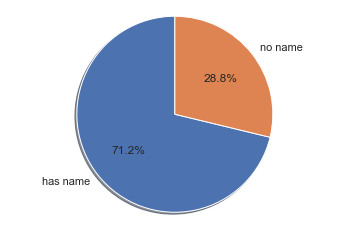

In [92]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'has name', 'no name'
sizes = [nameValues[1]/total, nameValues[0]/total]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Adjusted for the greater number of animals with vs without numbers, we have the following outcome rates by name:
- 5.4x more adoptions for animals with a name
- over 12x more returns to owner for animals with a name
- nearly 3x more transfers and euthanasia cases for animals without a name compared to named animals

Text(0.5, 1.0, "Animal Outcomes by 'hasName'")

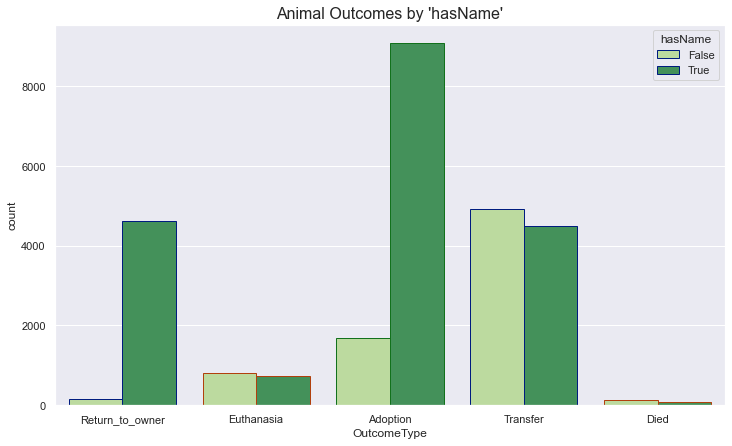

In [94]:
# print(ahs_train_df['OutcomeType'].groupby(ahs_train_df['AnimalType']).value_counts())
fig = plt.figure(figsize=(12, 7))
sns.set_theme(style="darkgrid")
sns.countplot(x="OutcomeType", hue="hasName", data=ahs_train_df, palette="YlGn", edgecolor=sns.color_palette("dark", 3))
plt.title("Animal Outcomes by 'hasName'", fontsize=16)

adjusted rates:

In [124]:
rates = ahs_train_df['OutcomeType'].groupby(ahs_train_df['hasName']).value_counts()
# print(rates)
print('Adoption ratio hasName True/False: {}'.format(str(rates[hasName[True]]["Adoption"]/rates[hasName==False]["Adoption"])))
print('Return to owner ratio cat/dog: {}'.format(str(0.405*rates[hasName[True]]["Return_to_owner"]/rates[hasName==False]["Return_to_owner"])))
print('Euthanasia ratio cat/dog: {}'.format(str(0.405*rates[hasName[True]]["Euthanasia"]/rates[hasName==False]["Euthanasia"])))
print('Transfer ratio cat/dog: {}'.format(str(0.405*rates[hasName[True]]["Transfer"]/rates[hasName==False]["Transfer"])))

Adoption ratio hasName True/False: 5.417759237187128
Return to owner ratio cat/dog: 12.263823529411766
Euthanasia ratio cat/dog: 0.3677300613496933
Transfer ratio cat/dog: 0.3698040609137056


Clearly, animals with a name are far more likely to be adopted and returned to their owner

__Most common breed types (as best defined by the shelter)__

In [125]:
breed_counts = ahs_train_df['Breed'].value_counts()
print("Most common 10 breeds overall: \n{}\n{}".format('-'*40, breed_counts[:10]))

breeds_by_animaltype = ahs_train_df.groupby(["AnimalType"])['Breed'].value_counts()
print("\nTop10 Cat breeds: \n{}\n{}".format('-'*40, breeds_by_animaltype['Cat'][:10]))
print("\nTop10 dog breeds: \n{}\n{}".format('-'*40, breeds_by_animaltype['Dog'][:10]))

Most common 10 breeds overall: 
----------------------------------------
Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Name: Breed, dtype: int64

Top10 Cat breeds: 
----------------------------------------
Breed
Domestic Shorthair Mix      8810
Domestic Medium Hair Mix     839
Domestic Longhair Mix        520
Siamese Mix                  389
Domestic Shorthair           143
Snowshoe Mix                  75
Maine Coon Mix                44
Manx Mix                      44
Domestic Medium Hair          42
Russian Blue Mix              33
Name: Breed, dtype: int64

Top10 dog breeds: 
----------------------------------------
Breed
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Lab

Overall, the most common breed marker for a shelter animal is 'Domestic Shorthair Mix' for felines. There are fewer cat categories for breed than dog, but similar numbers of cats to dogs, so more cats fall into this basket of domestic shorthair. There are more variations of dog breeds overall. But, some shelters are dropping these breed labels, both because the labels are inaccurate and since the label causes people to not see the animal behind the tag. <br>
- Below, you see there are 60 specific cat breeds but 1320! dog breeds

In [126]:
breeds = ahs_train_df.groupby(["AnimalType"])['Breed'].value_counts()
print("# cat breeds listed: {}".format(len(breeds["Cat"])))
print("# dog breeds listed: {}".format(len(breeds["Dog"])))

# cat breeds listed: 60
# dog breeds listed: 1320


<AxesSubplot:xlabel='count', ylabel='Breed'>

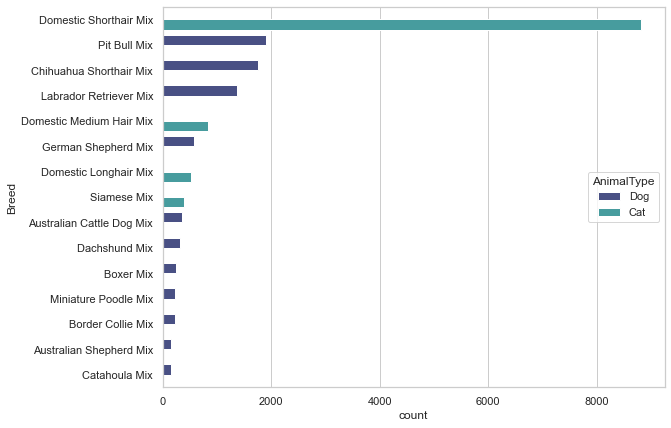

In [127]:
fig = plt.figure(figsize=(9, 7))
sns.set_theme(style="whitegrid")
sns.countplot(y="Breed", data=ahs_train_df, palette="mako", hue="AnimalType", order=ahs_train_df["Breed"].value_counts().iloc[:15].index)

We can engineer a feature based on whether the animal is a mix or not

In [128]:
def isMix(breed):
    return 'mix' in breed.lower()

In [129]:
isMix = [isMix(breed) for breed in ahs_train_df["Breed"]]

In [130]:
ahs_train_df["isMix"] = isMix

In [131]:
print(ahs_train_df["isMix"].value_counts())
mixVal = ahs_train_df["isMix"].value_counts()
total = mixVal[0] + mixVal[1]

True     22298
False     4431
Name: isMix, dtype: int64


the majority of rescue animals are indeed, mixed breed. Let us see if there are any differences in mixed vs purebreed animal outcomes:

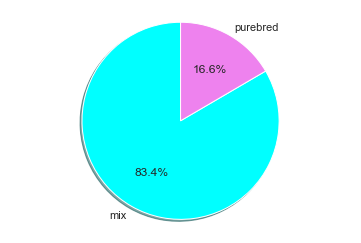

In [314]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'mix', 'purebred'
sizes = [mixVal[True]/total, mixVal[False]/total]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=['cyan','violet'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

view adjusted rates

In [142]:
rates = ahs_train_df['OutcomeType'].groupby(ahs_train_df['isMix']).value_counts()
print(rates)
print('\nAdoption ratio purebred/mix: {}'.format(str(round(5.88*rates[False]["Adoption"]/rates[True]["Adoption"], 2))))
print('Return to owner purebred/mix: {}'.format(str(round(5.88*rates[False]["Return_to_owner"]/rates[True]["Return_to_owner"], 2))))
print('Euthanasia ratio purebred/mix: {}'.format(str(round(5.88*rates[False]["Euthanasia"]/rates[True]["Euthanasia"],2))))
print('Transfer ratio purebred/mix: {}'.format(str(round(5.88*rates[False]["Transfer"]/rates[True]["Transfer"], 2))))
print('Died ratio purebred/mix: {}'.format(str(round(5.88*rates[False]["Died"]/rates[True]["Died"], 2))))

mixRate = ahs_train_df['isMix'].value_counts()
print('\nFraction of purebreds to all dogs: {}'.format(str(round(mixRate[False]/(mixRate[True]+mixRate[False]),2))))

isMix  OutcomeType    
False  Adoption           1977
       Transfer           1170
       Return_to_owner    1076
       Euthanasia          191
       Died                 17
True   Adoption           8792
       Transfer           8252
       Return_to_owner    3710
       Euthanasia         1364
       Died                180
Name: OutcomeType, dtype: int64

Adoption ratio purebred/mix: 1.32
Return to owner purebred/mix: 1.71
Euthanasia ratio purebred/mix: 0.82
Transfer ratio purebred/mix: 0.83
Died ratio purebred/mix: 0.56

Fraction of purebreds to all dogs: 0.17


we see upon adjustment for relative numbers:
- 1.3x more adoptions for purebreds than mixes, as well as 1.7x more returns to owner
- More mixes suffer euthanasia, are transferred or die in shelter compared to purebreds 

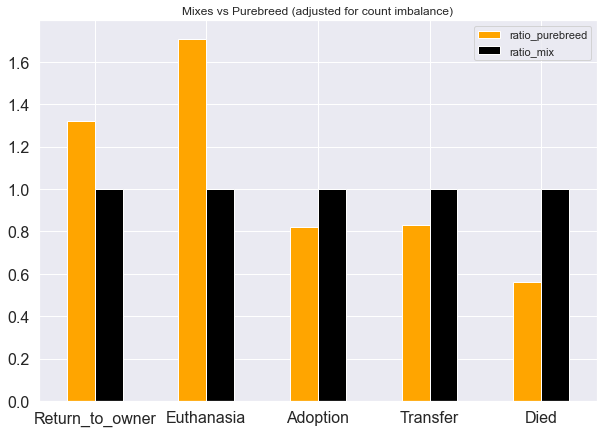

In [173]:
mix_ratios_purebreed = [1.32, 1.71, 0.82, 0.83, 0.56]
mix = [1,1,1,1,1]
x_cat = ["Return_to_owner", "Euthanasia", "Adoption", "Transfer", "Died"]
df = pd.DataFrame({'ratio_purebreed': mix_ratios_purebreed,
                    'ratio_mix': mix}, index=x_cat)

# fig = plt.subplots(figsize=(12,8))
sns.set_theme(style="darkgrid")
plt = df.plot.bar(rot=0, color={"ratio_purebreed": "orange", "ratio_mix": "black"}, figsize=(10,7), title="Mixes vs Purebreed (adjusted for count imbalance)", fontsize=16)

So, although purebreds only represent 17% of all shelter animals, they account for 22% of adoptions, 29% of returns to owner, and an underrepresentation of 14% for euthanasio and transfer ratio.

# 2) Deal with Null values and Encode Categorical Variables

In [183]:
ahs_train = ahs_train_df.copy()
ahs_train = ahs_train[["OutcomeType", "AnimalType", "ageYrs", "neutOrSpay",
                          "colGroup", "hasName", "isMix"]]

In [184]:
print(ahs_train_df.dtypes)

OutcomeType     object
AnimalType      object
ageYrs         float64
neutOrSpay      object
colGroup        object
hasName          int32
isMix            int32
dtype: object


convert boolean features to ints

In [186]:
ahs_train["hasName"] = ahs_train["hasName"].astype(int)
ahs_train["isMix"] = ahs_train["isMix"].astype(int)
print(ahs_train.head())
print(ahs_train.dtypes)

       OutcomeType AnimalType  ageYrs neutOrSpay  colGroup  hasName  isMix
0  Return_to_owner        Dog   1.000       True      dark        1      1
1       Euthanasia        Cat   1.000       True     light        1      1
2         Adoption        Dog   2.000       True  coloured        1      1
3         Transfer        Cat   0.058      False  coloured        0      1
4         Transfer        Dog   2.000       True     light        0      0
OutcomeType     object
AnimalType      object
ageYrs         float64
neutOrSpay      object
colGroup        object
hasName          int32
isMix            int32
dtype: object


'ageYrs', hasName and isMix are the only numeric variables at this point. So, we need to convert the other categorical variables to numeric. We can isolate these variables first and then convert them to categorical using pandas series encodings

In [188]:
obj_df = ahs_train_df.select_dtypes(include=['object']).copy()
obj_df.head()

,OutcomeType,AnimalType,neutOrSpay,colGroup
0,Return_to_owner,Dog,True,dark
1,Euthanasia,Cat,True,light
2,Adoption,Dog,True,coloured
3,Transfer,Cat,False,coloured
4,Transfer,Dog,True,light


Deal with any of the null values. It appears there are many null values for the neuter/spay variable. How should we deal with these null values? We can choose to propagate non-null values backward or forward to try to replicate the existing distribution

In [193]:
print(obj_df[obj_df.isnull().any(axis=1)])
print(len(obj_df[obj_df.isnull().any(axis=1)]))

      OutcomeType AnimalType neutOrSpay  colGroup
7        Transfer        Cat        NaN      dark
10       Transfer        Cat        NaN     black
64       Transfer        Cat        NaN     black
68       Transfer        Cat        NaN      dark
81     Euthanasia        Cat        NaN  coloured
...           ...        ...        ...       ...
26571    Transfer        Cat        NaN     light
26660    Transfer        Cat        NaN     black
26673    Transfer        Cat        NaN     black
26707  Euthanasia        Cat        NaN      dark
26719    Transfer        Cat        NaN      dark

[1094 rows x 4 columns]
1094


In [195]:
obj_df = obj_df.fillna(method='ffill')

In [196]:
obj_df[obj_df.isnull().any(axis=1)]

,OutcomeType,AnimalType,neutOrSpay,colGroup


In [197]:
print(obj_df.dtypes)
print(obj_df.head())
print(obj_df["OutcomeType"].value_counts())

OutcomeType    object
AnimalType     object
neutOrSpay       bool
colGroup       object
dtype: object
       OutcomeType AnimalType  neutOrSpay  colGroup
0  Return_to_owner        Dog        True      dark
1       Euthanasia        Cat        True     light
2         Adoption        Dog        True  coloured
3         Transfer        Cat       False  coloured
4         Transfer        Dog        True     light
Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64


__label encoding on the object features__

In [198]:
c = ahs_train_df["OutcomeType"].astype('category')
d = dict(enumerate(c.cat.categories))
print (d)

{0: 'Adoption', 1: 'Died', 2: 'Euthanasia', 3: 'Return_to_owner', 4: 'Transfer'}


In [199]:
obj_df["OutcomeType"] = (obj_df["OutcomeType"].astype('category')).cat.codes
obj_df["AnimalType"] = (obj_df["AnimalType"].astype('category')).cat.codes
obj_df["neutOrSpay"] = (obj_df["neutOrSpay"].astype('category')).cat.codes
obj_df["colGroup"] = (obj_df["colGroup"].astype('category')).cat.codes

In [200]:
print(obj_df.dtypes)
print(obj_df.head())

OutcomeType    int8
AnimalType     int8
neutOrSpay     int8
colGroup       int8
dtype: object
   OutcomeType  AnimalType  neutOrSpay  colGroup
0            3           1           1         2
1            2           0           1         3
2            0           1           1         1
3            4           0           0         1
4            4           1           1         3


In [203]:
ahs_train["OutcomeType"] = obj_df["OutcomeType"]
ahs_train["AnimalType"] = obj_df["AnimalType"]
ahs_train["neutOrSpay"] = obj_df["neutOrSpay"]
ahs_train["colGroup"] = obj_df["colGroup"]

In [206]:
print(ahs_train.head())

   OutcomeType  AnimalType  ageYrs  neutOrSpay  colGroup  hasName  isMix
0            3           1   1.000           1         2        1      1
1            2           0   1.000           1         3        1      1
2            0           1   2.000           1         1        1      1
3            4           0   0.058           0         1        0      1
4            4           1   2.000           1         3        0      0


There still a handful of examples where the animal age is unknown. replace by median age

In [208]:
print(ahs_train[ahs_train.isnull().any(axis=1)])
ahs_train["ageYrs"] = ahs_train["ageYrs"].replace([np.nan], 1)

       OutcomeType  AnimalType  ageYrs  neutOrSpay  colGroup  hasName  isMix
2480             4           0     NaN           0         1        0      1
2912             4           0     NaN           1         2        0      1
3766             4           0     NaN           0         2        0      1
3875             2           1     NaN           0         3        0      1
4498             4           0     NaN           0         2        0      1
5137             4           0     NaN           1         0        0      1
5691             4           0     NaN           0         0        0      1
7005             4           0     NaN           1         0        0      1
8420             4           0     NaN           0         1        0      1
17464            4           0     NaN           0         1        0      1
18490            4           0     NaN           0         2        0      1
19927            4           0     NaN           0         1        0      1

In [209]:
ahs_train_df[ahs_train_df.isnull().any(axis=1)]

,OutcomeType,AnimalType,ageYrs,neutOrSpay,colGroup,hasName,isMix


Now we have successfully dealt with the null values and converted the columns to numeric types

In [211]:
print(ahs_train.dtypes)

OutcomeType       int8
AnimalType        int8
ageYrs         float64
neutOrSpay        int8
colGroup          int8
hasName          int32
isMix            int32
dtype: object


# 3) Classification: XGBoost & naive bayes

In [230]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
import graphviz
from xgboost import plot_tree

In [218]:
# recall the outcome classes:
print (d)

{0: 'Adoption', 1: 'Died', 2: 'Euthanasia', 3: 'Return_to_owner', 4: 'Transfer'}


In [214]:
train_cols = ["AnimalType", "ageYrs", "neutOrSpay", "colGroup", "hasName", "isMix"]

In [215]:
x_train, x_test, y_train, y_test = train_test_split(ahs_train[train_cols], ahs_train["OutcomeType"], test_size=0.2, random_state=0)

In [216]:
trueOutcome = []
for x in x_test.index:
    trueOutcome.append(ahs_train_df.loc[x, "OutcomeType"])

In [217]:
print(trueOutcome[:15])

[3, 0, 3, 4, 0, 0, 4, 0, 0, 4, 0, 2, 3, 0, 0]


In [222]:
# Gaussian Naive Bayes
gnb = GaussianNB()

#XGBoost
xgb = XGBClassifier()

In [224]:
#gaussian naive bayes classifier
y_GNB_pred = gnb.fit(x_train, y_train).predict(x_test)
y_gnb_prob = gnb.predict_proba(x_test)

#xgboost classifier
y_xgb_pred = xgb.fit(x_train, y_train).predict(x_test);
y_xgb_prob = xgb.predict_proba(x_test)

__confusion matrices__

as expected, the classifiers perform best on the classes with the most training examples: adoption and transfers

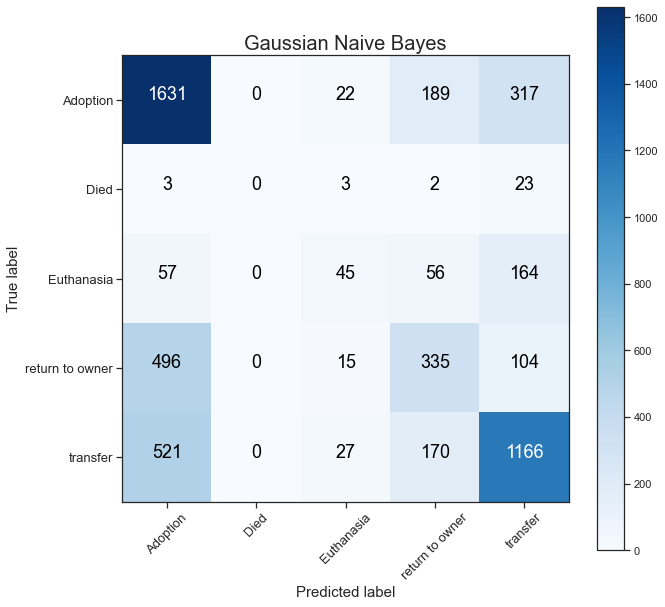

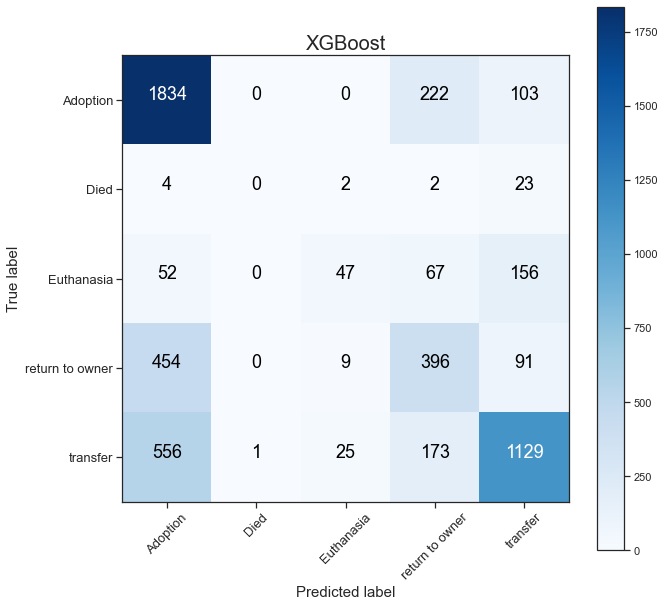

In [243]:
class_labels = ('Adoption', 'Died', 'Euthanasia', 'return to owner', 'transfer')
ptool.plot_confusion_matrix(classes=class_labels, model="Gaussian Naive Bayes", pred=y_GNB_pred,
                           labels=trueOutcome, figsize=(10,10))
plt.savefig('cm_GNB.png', bbox_inches='tight', dpi=600 )

class_labels = ('Adoption', 'Died', 'Euthanasia', 'return to owner', 'transfer')
ptool.plot_confusion_matrix(classes=class_labels, model="XGBoost", pred=y_xgb_pred,
                           labels=trueOutcome, figsize=(10,10))
plt.savefig('cm_XGB.png', bbox_inches='tight', dpi=600 )

__classification reports and metrics__

In [244]:
# recall the outcome classes:
print (d)

{0: 'Adoption', 1: 'Died', 2: 'Euthanasia', 3: 'Return_to_owner', 4: 'Transfer'}


Several insights may be drawn from the following classification report:
- the 'died' category has the fewest examples, and given the sparsity in the test set, there were no correct predictions in the category! Given the extreme class imbalance here, it is not unexpected
- Performance was best in the largest two categories: Adoption and Transfers. Naive Bayes provides an f1-score for these categories of 0.67 and 0.64 resp., while XGBoost outperforms with f1-score of 0.73 and 0.67 resp. 
- Overall, Naive Bayes gives a general accuray across all categories of 59% while XGBoost does better predictively with a 64% accuracy
- both models demonstrate some ability to predict transfers and returns to owner, although these classes, with fewer examples, are definitely harder to predict

In [231]:
#naive bayes
print("-"*50 + "\nGaussian Naive Bayes: ")
print(classification_report(trueOutcome, y_GNB_pred))

#xgboost
print("\n" + "-"*50 + "\nXGBoost: ")
print(classification_report(trueOutcome, y_xgb_pred))

--------------------------------------------------
Gaussian Naive Bayes: 
              precision    recall  f1-score   support

           0       0.60      0.76      0.67      2159
           1       0.00      0.00      0.00        31
           2       0.40      0.14      0.21       322
           3       0.45      0.35      0.39       950
           4       0.66      0.62      0.64      1884

    accuracy                           0.59      5346
   macro avg       0.42      0.37      0.38      5346
weighted avg       0.58      0.59      0.58      5346


--------------------------------------------------
XGBoost: 
              precision    recall  f1-score   support

           0       0.63      0.85      0.73      2159
           1       0.00      0.00      0.00        31
           2       0.57      0.15      0.23       322
           3       0.46      0.42      0.44       950
           4       0.75      0.60      0.67      1884

    accuracy                           0.64      

C:\Users\Mattz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


__Feature Importance XGB__

Let's see which features XGB deemed most important to get insight into the relevance of the various features

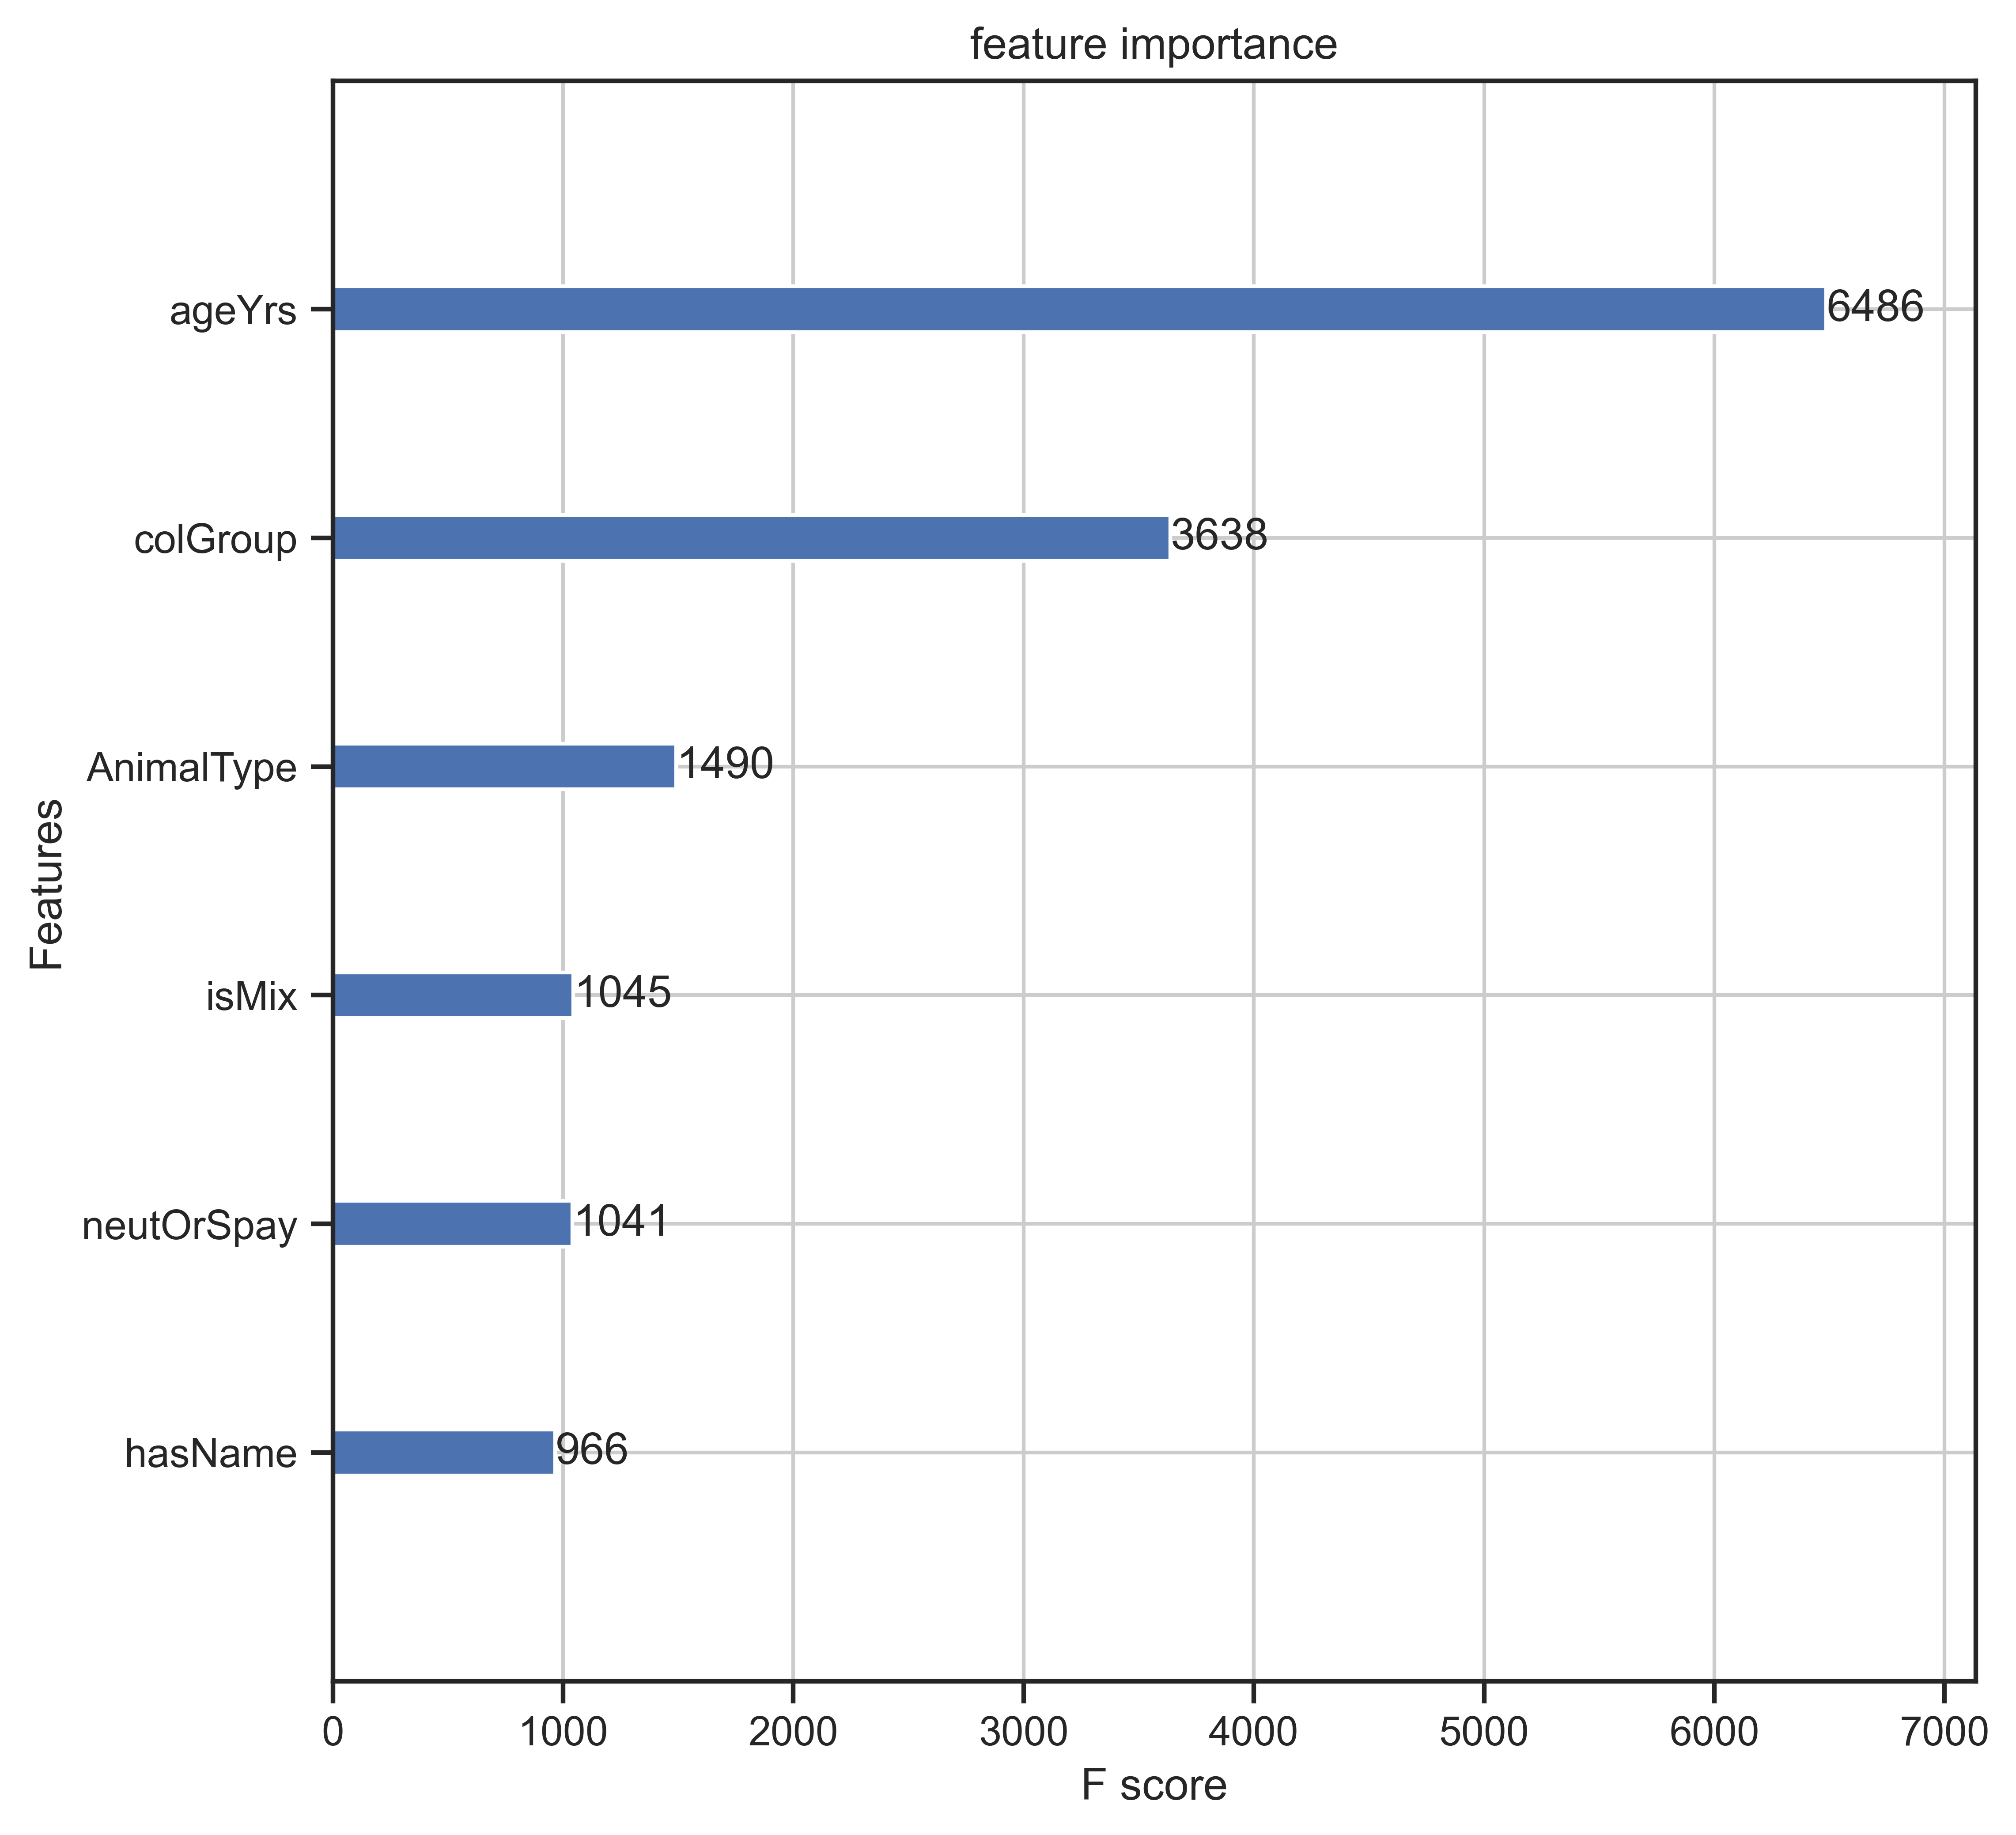

In [282]:
ptool.my_plot_importance(xgb, (8,8), "feature importance") 

Interestingly, while I expected age to be an important discriminating factor, it appears that that colour group is also quite important in predicting outcomes for the shelter animals! animal type is, predictably, also quite important

# Concluding Thoughts

Overall, this was a very interesting project to work on and a good experience working with mostly categorical data, cleaning up the dataset and extracting new features.

Thoughts from the Exploratory Data Analysis (EDA):
- this was an imbalanced dataset, with most examples of adoptions and transfers. The fewer numbers of returns to owner, euthanasia and deaths in shelter led to these categories being more difficult to predict.
- Age is predictably a very strong predictor of outcome across all outcome classes. Many more kittens and puppies are adopted than older animals. As shelters certainly already do, they should focus on promoting the benefits of adopting older animals 
- Nearly all adoptions are for neutered/spayed animals. This stresses the importance of spaying/neutering animals, not to mention other benefits like reducing animal overpopulation
- There are very different outcome for cats and dogs. 0.16% of cats will be returned to owners compared to dogs and almost 2x more cats will be transferred to another shelther than dogs
- Of all the shelter animals, ~70% have names and 30% do not. There were 5.4x more adoptions for animals with a name and over 12x more returns to owner for animals with a name. This stresses the notion: give shelter animals a name, and preferably a memorable one at that!
- although purebreds only represent 17% of all shelter animals, they account for 22% of adoptions, 29% of returns to owner, and an underrepresentation of 14% for euthanasio and transfer ratio. Shelters could use this information and campaign to promote the benefits of adopting mutts

Thoughts from the MultiClass classification:
- overall, two models were tested: Naive Bayes and XGBoost. XGBoost outperformed Naive Bayes, scoring an overall accuracy of 64% and f1 scores of 73% and 67% for adoption and transfer cases respectively. Returns to owner, deaths in shelter and euthanasia cases proved difficult to predict due to underrepresentation in the dataset
- The EDA did not indicant a particular importance of animal colour to animal outcome, but the XGBoost feature importance ended up using this feature second only to animal ages to construct its decision models. This indicates that animal colour is an important factor to adopters, and more attention could be paid in the feature engineering of this category.
- Overall, animal outcome prediction remains a difficult task, but there are several insights this analysis affords. By recognizing trends in adoptions transfers, etc., shelters can focus on strategies to help all of the animals in their case. 

Shelter recommendations from analysis:
- Name all the animals in the shelter
- Promote the older animals, and those with darker colours, with special care
- Neuter/spay animals in care as quickly as possible